# M5 Forecast: Keras with Categorical Embeddings V2

В этом ноутбуке происходит моделирование ожидаемой продажи групп продуктов. Поскольку многие фичи являются категориальными, мы используем этот пример, чтобы показать, как встраивание словев облегчает жизнь при работе с категориальными входами для нейронных сетей, прокуская этап создания фиктивных переменных вручную.

In [1]:
start_day = 0

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
from tqdm.notebook import tqdm

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Загрузка данных

In [4]:
path = "./kaggle/input/"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [5]:
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

## Описание и подготовка данных

Теперь пройдемся по всем наборам данных и подготовим их к моделированию.

### Календарь

Для каждой даты (охватывающей как даные обучения, так и данные испытаний) у нас есть доступ к полезной информации календаря.

In [6]:
calendar.head(5)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


Визуализация данных календаря:

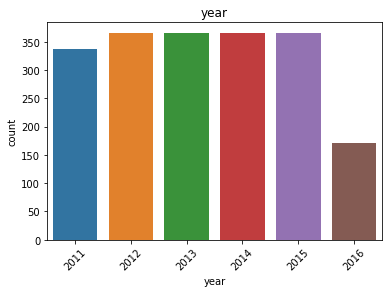

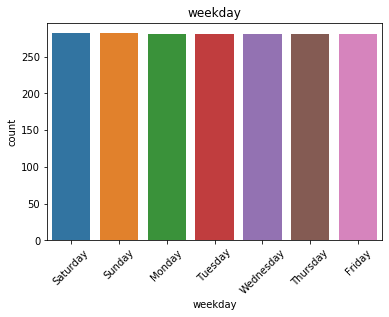

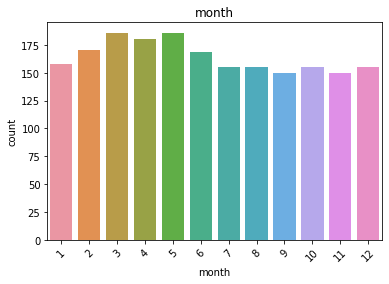

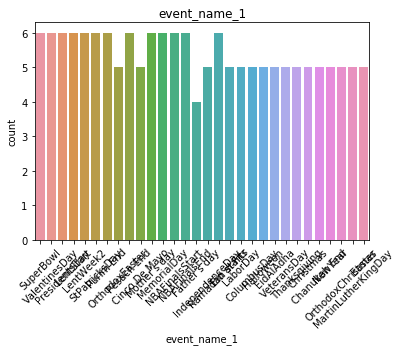

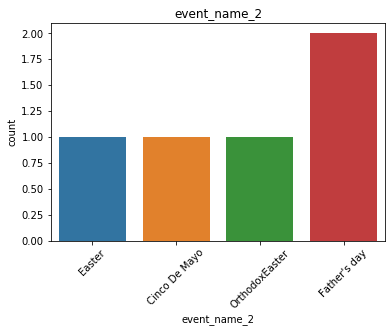

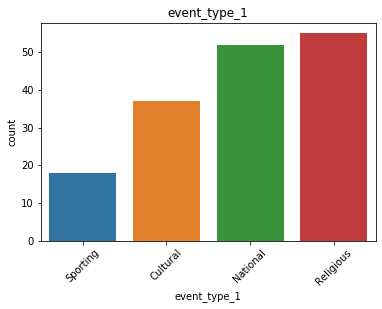

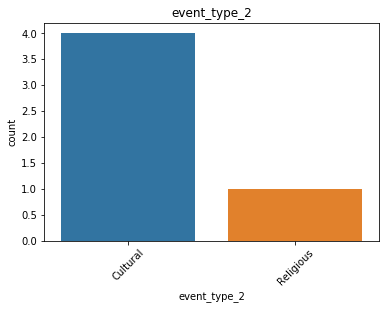

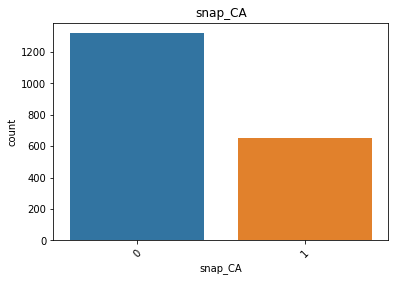

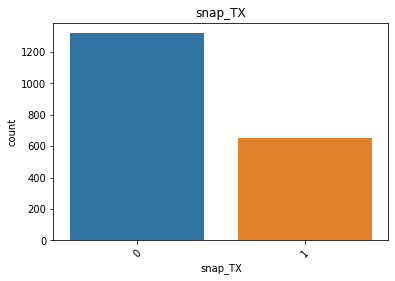

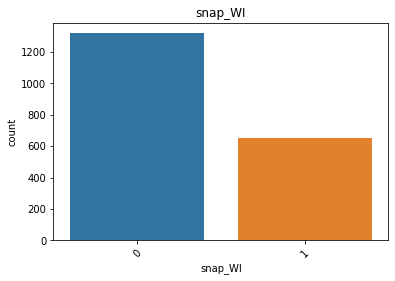

In [7]:
for i, var in enumerate(["year", "weekday", "month", "event_name_1", "event_name_2", 
                         "event_type_1", "event_type_2", "snap_CA", "snap_TX", "snap_WI"]):
    plt.figure()
    g = sns.countplot(calendar[var])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(var)

In [8]:
calendar.head(1)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0


Подготовка календаря: удаление даты и дня недели, приведение столбца d к целому типу, заполнение пропущенных данных (праздников) значением 'missing' и кодирование категориальных признаков в виде целочисленного массива 

In [9]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int)) # Обработка значение столбца d
    df = df.fillna("missing")
    cols = list(set(df.columns) - {"wm_yr_wk", "d"})
    df[cols] = OrdinalEncoder(dtype="int").fit_transform(df[cols])
    df = reduce_mem_usage(df)
    return df

calendar = prep_calendar(calendar)

Mem. usage decreased to  0.03 Mb (84.7% reduction)


In [10]:
calendar.head(5)

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,11101,0,0,0,1,30,4,4,2,0,0,0
1,11101,1,0,0,2,30,4,4,2,0,0,0
2,11101,2,0,0,3,30,4,4,2,0,0,0
3,11101,3,1,0,4,30,4,4,2,1,1,0
4,11101,4,1,0,5,30,4,4,2,1,0,1


#### Заметки для моделирования

**Фичи** считаются полезными

- "wday", "year", "month" -> integer coding & embedding
- "event_name_1", "event_type_1" -> integer coding & embedding
- "snap_XX" -> numeric (they are dummies)

**Необходимость решейпа**: Нет

**Объединение ключей**: "d", "wm_yr_wk"

### Цены продажи

Содержит цены продаж для каждой комбинации store_id, item_id, wm_yr_wk.

In [11]:
selling_prices.head(5)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [12]:
selling_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


Получение фич, связанных со временем: изменение цены в сравнении с предыдущей неделей, скользящее стандартное отклонение за 2, 4 и 7 недель, нормирование цены

In [13]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    sell_price_roll_sd_col = list()
    for i in [2,4,7]:
        df["sell_price_roll_sd"+str(i)] = gr.transform(lambda x: x.rolling(i).std())
        sell_price_roll_sd_col.append("sell_price_roll_sd"+str(i))
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df = reduce_mem_usage(df)
    return df, sell_price_roll_sd_col

selling_prices, sell_price_roll_sd_col = prep_selling_prices(selling_prices)

Mem. usage decreased to 195.73 Mb (58.3% reduction)


In [14]:
selling_prices.head(5)

,store_id,item_id,wm_yr_wk,sell_price,sell_price_rel_diff,sell_price_roll_sd2,sell_price_roll_sd4,sell_price_roll_sd7,sell_price_cumrel
0,CA_1,HOBBIES_1_001,11325,9.578125,NaN,NaN,NaN,NaN,0.0
1,CA_1,HOBBIES_1_001,11326,9.578125,0.000000,0.000000,NaN,NaN,0.0
2,CA_1,HOBBIES_1_001,11327,8.257812,-0.137817,0.933594,NaN,NaN,0.0
3,CA_1,HOBBIES_1_001,11328,8.257812,0.000000,0.000000,0.762207,NaN,0.0
4,CA_1,HOBBIES_1_001,11329,8.257812,0.000000,0.000000,0.660156,NaN,0.0


#### Заметки для моделирования

**Фичи**:

- sell_price и полученные фичи -> numeric

**Необходимость решейпа**: Нет

**Объединение ключей**: данные о продаже с store_id, item_id, wm_yr_wk (через данные календаря)

### Данные о продажах

Содержат число проданных товаров (то, что необходимо предсказать), а также некоторые категориальные фичи.

In [15]:
sales.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


Визуализация данных о продажах

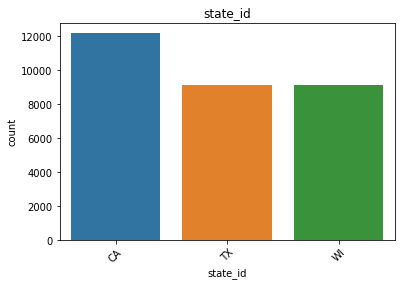

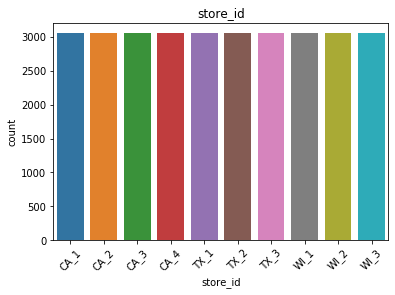

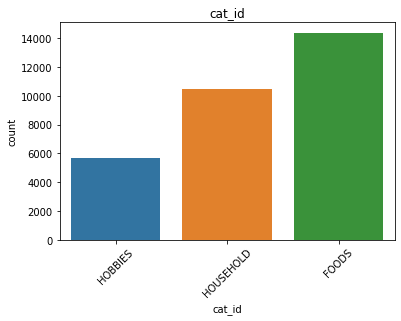

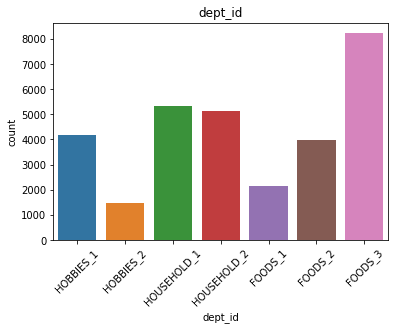

In [16]:
for i, var in enumerate(["state_id", "store_id", "cat_id", "dept_id"]):
    plt.figure()
    g = sns.countplot(sales[var])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(var)

Встречаемость каждого продукта

In [17]:
sales.item_id.value_counts()

FOODS_2_064        10
HOUSEHOLD_1_410    10
HOUSEHOLD_1_211    10
HOUSEHOLD_1_127    10
FOODS_1_144        10
                   ..
FOODS_3_134        10
HOUSEHOLD_2_471    10
HOBBIES_2_120      10
HOUSEHOLD_1_422    10
HOBBIES_1_021      10
Name: item_id, Length: 3049, dtype: int64

#### Решейпинг

Произведем решейп данных для получения "длинного" списка вместо "широкого". Используя фиксированный "id" и меняя столбцы "d_x". Также добавим структуру для данных сабмитта и уменьшим размер данных. 

In [18]:
def reshape_sales(df, drop_d = None): # drop_d позволяет выбрать день, после которого начнется построение списка
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1) # удаление столбцов со значениями ниже drop_d
    df = df.assign(id=df.id.str.replace("_validation", "")) # Обработка значения столбца id: удаление "_validation"
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)]) 
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], # добавление столбцов для предсказаний
                 var_name='d', value_name='demand') # решейпинг, т.е. преобразование столбцов с датами (d_1, d_2,..) 
                            # в один столбец "d" (значения d_1, d_2,...) и соответствующие ему хранившиеся значения продаж
    df = df.assign(d=df.d.str[2:].astype("int16")) # Обработка значения столбца "d": удаление "d_" из значения "d_<id>" 
    return df

sales = reshape_sales(sales, start_day)

Результат:

In [19]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0


#### Распределение покупок

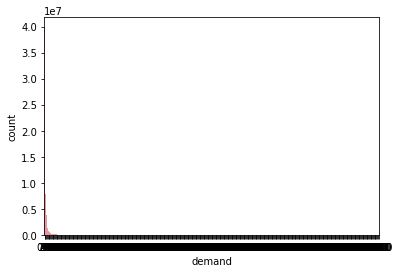

In [20]:
sns.countplot(sales["demand"]);

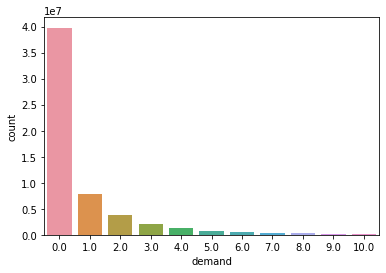

In [21]:
 sns.countplot(sales["demand"][sales["demand"]<= 10]);

#### Добавление фич, связанных с временным лагом

Добавление фич из https://www.kaggle.com/ragnar123/very-fst-model.

In [22]:
lag = 28
def prep_sales(df, lag):
    df['lag_t'+str(lag)] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(lag)) # Смещение данных на lag
    
    rolling_mean_col = list()
    for i in [7, 14, 28, 90, 180, 365]: # Скользящее среднее
        df['rolling_mean_t'+str(i)] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(lag).rolling(i).mean())
        rolling_mean_col.append('rolling_mean_t'+str(i))
    
    rolling_std_col = list()    
    for i in [7, 14, 28]: # Скользящее стандартное отклонение
        df['rolling_std_t'+str(i)] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(lag).rolling(i).std())
        rolling_std_col.append('rolling_std_t'+str(i))
    # Удаление строк с NA за исключением строк с предсказаниями.
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_t180))] # rolling_mean_t180 был выбран, т.к. производит большинство пропусков
    df = reduce_mem_usage(df)

    return df, rolling_mean_col, rolling_std_col

sales, rolling_mean_col, rolling_std_col = prep_sales(sales, lag)

Mem. usage decreased to 4098.77 Mb (45.2% reduction)


In [23]:
sales[sales.id == "HOBBIES_1_001_CA_1"].head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t14,rolling_mean_t28,rolling_mean_t90,rolling_mean_t180,rolling_mean_t365,rolling_std_t7,rolling_std_t14,rolling_std_t28
6311430,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
6341920,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
6372410,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
6402900,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
6433390,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0


#### Заметки для моделирования

**Фичи**
- "dept_id", "item_id", "store_id": Integer coding & embedding
- полученные фичи, связанные с временным лагом : Numeric

**Необходимость решейпа**:
- Решейп дней в "d" для формирования из широкого списка в длинный -> столбец "demand" содержит значения 

**Объединения ключей**:
1. Объединения календарных фичей через "d"
2. Объединение цен продаж через "store_id", "item_id" и ("wm_yr_wk" из календаря) 

Comment: Submission dates: "d_1914" - "d_1969"

### Объединение источников данных

Объединение данных о продаже и календаря

In [24]:
sales = sales.merge(calendar, how="left", on="d")
gc.collect() # Garbage Collector
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,208,0.0,0.0,0.000000,...,4,7,0,30,4,4,2,0,0,0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,208,1.0,0.0,0.142822,...,4,7,0,30,4,4,2,0,0,0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,208,0.0,0.0,0.000000,...,4,7,0,30,4,4,2,0,0,0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,208,1.0,0.0,1.428711,...,4,7,0,30,4,4,2,0,0,0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,208,0.0,0.0,0.000000,...,4,7,0,30,4,4,2,0,0,0


Объединение данных о продаже и цен

In [25]:
sales = sales.merge(selling_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd2,sell_price_roll_sd4,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,208,0.0,0.0,0.000000,...,2,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,208,1.0,0.0,0.142822,...,2,0,0,0,3.970703,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,208,0.0,0.0,0.000000,...,2,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,208,1.0,0.0,1.428711,...,2,0,0,0,4.339844,0.0,0.0,0.0,0.0,0.0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,208,0.0,0.0,0.000000,...,2,0,0,0,2.980469,0.0,0.0,0.0,0.0,0.0


In [26]:
del selling_prices

In [27]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53723380 entries, 0 to 53723379
Data columns (total 34 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   object 
 1   item_id              object 
 2   dept_id              object 
 3   cat_id               object 
 4   store_id             object 
 5   state_id             object 
 6   d                    int16  
 7   demand               float16
 8   lag_t28              float16
 9   rolling_mean_t7      float16
 10  rolling_mean_t14     float16
 11  rolling_mean_t28     float16
 12  rolling_mean_t90     float16
 13  rolling_mean_t180    float16
 14  rolling_mean_t365    float16
 15  rolling_std_t7       float16
 16  rolling_std_t14      float16
 17  rolling_std_t28      float16
 18  wday                 int8   
 19  month                int8   
 20  year                 int8   
 21  event_name_1         int8   
 22  event_type_1         int8   
 23  event_name_2         int8   
 

## Подготовка данных для Keras

### Кодирование оставшихся категорий

In [28]:
cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]
cat_cols = cat_id_cols + ["wday", "month", "year", "event_name_1", 
                          "event_type_1", "event_name_2", "event_type_2"]

# Минимизация использования памяти
for i, v in tqdm(enumerate(cat_id_cols)):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]])

sales = reduce_mem_usage(sales)
sales.head()
gc.collect()


Mem. usage decreased to 3483.95 Mb (17.1% reduction)


15

#### Подготовка численных колонок

In [29]:
num_cols = ["sell_price", "sell_price_rel_diff", "sell_price_cumrel"] + sell_price_roll_sd_col+ [('lag_t'+str(lag))] + rolling_mean_col + rolling_std_col 
bool_cols = ["snap_CA", "snap_TX", "snap_WI"]
dense_cols = num_cols + bool_cols

# Заполняем пропуски медианным значением
for i, v in tqdm(enumerate(num_cols)):
    sales[v] = sales[v].fillna(sales[v].median())
    
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd2,sell_price_roll_sd4,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,208,0.0,0.0,0.000000,...,2,0,0,0,3.470703,0.0,0.0,0.0,0.0,0.0
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,208,1.0,0.0,0.142822,...,2,0,0,0,3.970703,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,208,0.0,0.0,0.000000,...,2,0,0,0,3.470703,0.0,0.0,0.0,0.0,0.0
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,208,1.0,0.0,1.428711,...,2,0,0,0,4.339844,0.0,0.0,0.0,0.0,0.0
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,208,0.0,0.0,0.000000,...,2,0,0,0,2.980469,0.0,0.0,0.0,0.0,0.0


In [30]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd2,sell_price_roll_sd4,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,208,0.0,0.0,0.000000,...,2,0,0,0,3.470703,0.0,0.0,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,208,1.0,0.0,0.142822,...,2,0,0,0,3.970703,0.0,0.0,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,208,0.0,0.0,0.000000,...,2,0,0,0,3.470703,0.0,0.0,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,208,1.0,0.0,1.428711,...,2,0,0,0,4.339844,0.0,0.0,0.0,0.0,0.000000
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,208,0.0,0.0,0.000000,...,2,0,0,0,2.980469,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53723375,FOODS_3_823_WI_3,1432,2,0,9,2,1969,NaN,0.0,0.285645,...,0,0,0,0,2.980469,0.0,0.0,0.0,0.0,0.333252
53723376,FOODS_3_824_WI_3,1433,2,0,9,2,1969,NaN,0.0,0.285645,...,0,0,0,0,2.480469,0.0,0.0,0.0,0.0,0.285645
53723377,FOODS_3_825_WI_3,1434,2,0,9,2,1969,NaN,0.0,0.285645,...,0,0,0,0,3.980469,0.0,0.0,0.0,0.0,0.000000
53723378,FOODS_3_826_WI_3,1435,2,0,9,2,1969,NaN,0.0,0.285645,...,0,0,0,0,1.280273,0.0,0.0,0.0,0.0,0.000000


#### Разделение тестовых данных и восстановление столбцов с id (validation, evaluation)

In [31]:
test = sales[sales.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))

gc.collect()
test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd2,sell_price_roll_sd4,sell_price_roll_sd7,sell_price_cumrel,F
52015940,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1914,NaN,1.0,1.142578,...,0,0,0,8.382812,0.0,0.0,0.059998,0.064148,0.051727,F1
52015941,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1914,NaN,1.0,0.714355,...,0,0,0,3.970703,0.0,0.0,0.000000,0.000000,0.000000,F1
52015942,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,1914,NaN,0.0,0.285645,...,0,0,0,2.970703,0.0,0.0,0.000000,0.000000,0.000000,F1
52015943,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1914,NaN,0.0,3.000000,...,0,0,0,4.640625,0.0,0.0,0.000000,0.000000,0.230713,F1
52015944,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1914,NaN,1.0,0.714355,...,0,0,0,2.880859,0.0,0.0,0.000000,0.000000,0.250000,F1


In [32]:
test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd2,sell_price_roll_sd4,sell_price_roll_sd7,sell_price_cumrel,F
52015940,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1914,NaN,1.0,1.142578,...,0,0,0,8.382812,0.0,0.0,0.059998,0.064148,0.051727,F1
52015941,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1914,NaN,1.0,0.714355,...,0,0,0,3.970703,0.0,0.0,0.000000,0.000000,0.000000,F1
52015942,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,1914,NaN,0.0,0.285645,...,0,0,0,2.970703,0.0,0.0,0.000000,0.000000,0.000000,F1
52015943,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1914,NaN,0.0,3.000000,...,0,0,0,4.640625,0.0,0.0,0.000000,0.000000,0.230713,F1
52015944,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1914,NaN,1.0,0.714355,...,0,0,0,2.880859,0.0,0.0,0.000000,0.000000,0.250000,F1


## Полносвязная модель

### Создание обучающего набора данных

In [33]:
# Подготовка данных
# Создание словаря чисел для слоя dense и деление входящих данных на каждый embedding вход
def make_X(df):
    X = {"dense1": df[dense_cols].to_numpy()}
    for i, v in enumerate(cat_cols):
        X[v] = df[[v]].to_numpy()
    return X

In [34]:
# Submission data
X_test = make_X(test)

In [35]:
# Месяц для валидации данных
flag = (sales.d < 1914) & (sales.d >= 1914 - 28)
valid = (make_X(sales[flag]),
         sales["demand"][flag])

# Остальное для тренировки
flag = sales.d < 1914 - 28
X_train = make_X(sales[flag])
y_train = sales["demand"][flag]
                             
del sales, flag
gc.collect()

20

In [36]:
np.unique(X_train["state_id"])

array([0, 1, 2], dtype=int8)

In [37]:
X_train

{'dense1': array([[3.47, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [3.97, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [3.47, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [3.98, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [1.28, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]], dtype=float16),
 'item_id': array([[1437],
        [1438],
        [1439],
        ...,
        [1434],
        [1435],
        [1436]], dtype=int16),
 'dept_id': array([[3],
        [3],
        [3],
        ...,
        [2],
        [2],
        [2]], dtype=int8),
 'store_id': array([[0],
        [0],
        [0],
        ...,
        [9],
        [9],
        [9]], dtype=int8),
 'cat_id': array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]], dtype=int8),
 'state_id': array([[0],
        [0],
        [0],
        ...,
        [2],
        [2],
        [2]], dtype=int8),
 'wday': array([[4],
        [4],
        [4],
       

### Imports

In [38]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten, SimpleRNN, Reshape, LSTM
from tensorflow.keras.models import Model, Sequential

### Архитектура

In [49]:
def create_model(lr=0.002):
    tf.random.set_seed(173)

    tf.keras.backend.clear_session()
    gc.collect()

    # Ввод числовых данных
    dense_input = Input(shape=(len(dense_cols), ), name='dense1')

    # Ввод категориальных данных
    
    wday_input = Input(shape=(1,), name='wday')
    month_input = Input(shape=(1,), name='month')
    year_input = Input(shape=(1,), name='year')
    event_name_1_input = Input(shape=(1,), name='event_name_1')
    event_type_1_input = Input(shape=(1,), name='event_type_1')
    event_name_2_input = Input(shape=(1,), name='event_name_2')
    event_type_2_input = Input(shape=(1,), name='event_type_2')
    item_id_input = Input(shape=(1,), name='item_id')
    dept_id_input = Input(shape=(1,), name='dept_id')
    store_id_input = Input(shape=(1,), name='store_id')
    cat_id_input = Input(shape=(1,), name='cat_id')
    state_id_input = Input(shape=(1,), name='state_id')

    # Обработка категориальных данных слоями Flatten
    wday_emb = Flatten()(Embedding(7, 1)(wday_input))
    month_emb = Flatten()(Embedding(12, 1)(month_input))
    year_emb = Flatten()(Embedding(6, 1)(year_input))
    event_name_1_emb = Flatten()(Embedding(31, 1)(event_name_1_input))
    event_type_1_emb = Flatten()(Embedding(5, 1)(event_type_1_input))
    event_name_2_emb = Flatten()(Embedding(5, 1)(event_name_2_input))
    event_type_2_emb = Flatten()(Embedding(5, 1)(event_type_2_input))

    item_id_emb = Flatten()(Embedding(3049, 30)(item_id_input))#3
    dept_id_emb = Flatten()(Embedding(7, 1)(dept_id_input))
    store_id_emb = Flatten()(Embedding(10, 1)(store_id_input))
    cat_id_emb = Flatten()(Embedding(3, 1)(cat_id_input))
    state_id_emb = Flatten()(Embedding(3, 1)(state_id_input))
    
    # Совмещение числовых и категориальных частей и добавление полносвязных слоев. На выходе линейная функция активации.
    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input, wday_emb, month_emb, year_emb, 
                     event_name_1_emb, event_type_1_emb, 
                     event_name_2_emb, event_type_2_emb, 
                     item_id_emb, dept_id_emb, store_id_emb,
                     cat_id_emb, state_id_emb])
    x = Dense(250, activation="tanh")(x)
    x = Dense(150, activation="tanh")(x)
    x = Dense(75, activation="tanh")(x)
    x = Dense(10, activation="tanh")(x)
    outputs = Dense(1, activation="linear", name='output')(x)

    inputs = {"dense1": dense_input, "wday": wday_input, "month": month_input, "year": year_input, 
              "event_name_1": event_name_1_input, "event_type_1": event_type_1_input,
              "event_name_2": event_name_2_input, "event_type_2": event_type_2_input,
              "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input, 
              "cat_id": cat_id_input, "state_id": state_id_input}

    # Соединение входа и выхода
    model = Model(inputs, outputs)

    model.compile(loss=keras.losses.mean_squared_error,
                  metrics=[tf.keras.metrics.RootMeanSquaredError()],
                  optimizer=keras.optimizers.RMSprop(learning_rate=lr))
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wday (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
year (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
event_name_1 (InputLayer)       [(None, 1)]          0                                            
______________________________________________________________________________________________

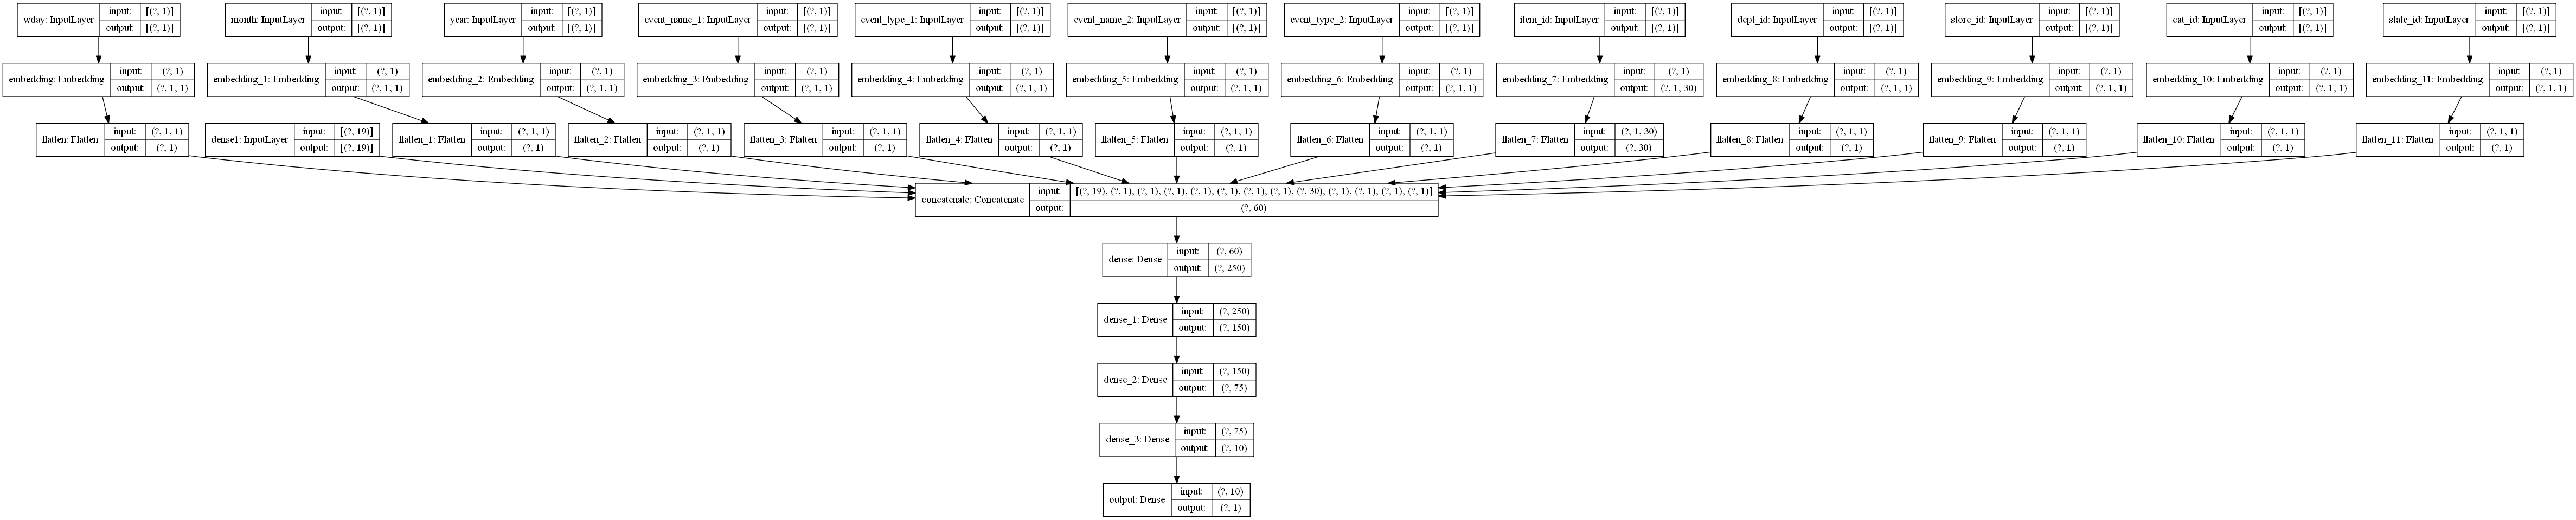

In [50]:
model = create_model(0.0002)
model.summary()
keras.utils.plot_model(model, 'model.png', show_shapes=True)

### Обучение модели

In [51]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=10000,
                    epochs=30,
                    shuffle=True,
                    validation_data=valid)

Train on 51162220 samples, validate on 853720 samples
Epoch 1/30
51162220/51162220 [==============================] - 51s 1us/sample - loss: 10.5905 - root_mean_squared_error: 3.2543 - val_loss: 6.9148 - val_root_mean_squared_error: 2.6296
Epoch 2/30
51162220/51162220 [==============================] - 47s 1us/sample - loss: 8.5006 - root_mean_squared_error: 2.9156 - val_loss: 5.9625 - val_root_mean_squared_error: 2.4418
Epoch 3/30
51162220/51162220 [==============================] - 47s 1us/sample - loss: 7.7436 - root_mean_squared_error: 2.7827 - val_loss: 5.5756 - val_root_mean_squared_error: 2.3613
Epoch 4/30
51162220/51162220 [==============================] - 47s 1us/sample - loss: 7.3463 - root_mean_squared_error: 2.7104 - val_loss: 5.3412 - val_root_mean_squared_error: 2.3111
Epoch 5/30
51162220/51162220 [==============================] - 47s 1us/sample - loss: 7.0754 - root_mean_squared_error: 2.6600 - val_loss: 5.2272 - val_root_mean_squared_error: 2.2863
Epoch 6/30
51162220/

#### Построение графика метрики по эпохам

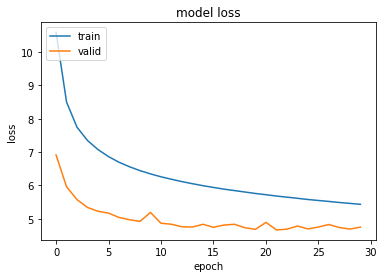

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [53]:
history.history["val_loss"]

[6.914766116424447,
 5.962462244488242,
 5.575572080164903,
 5.341237819078059,
 5.227183146356771,
 5.172347422387413,
 5.042025266142508,
 4.974564893664714,
 4.9245596531209035,
 5.192341346121413,
 4.868160625264375,
 4.838733736925707,
 4.7632458970165015,
 4.755258793762283,
 4.837600621344675,
 4.748036683334639,
 4.814702447160128,
 4.837956787200171,
 4.733646276824584,
 4.686917920884066,
 4.894472323780804,
 4.669099434343792,
 4.690899707292129,
 4.785411659580851,
 4.699259619410547,
 4.755810169417828,
 4.830732635083744,
 4.7394166431526195,
 4.694086893202578,
 4.751746862913113]

In [54]:
model.save('model4.h5')

### Submission

In [55]:
pred = model.predict(X_test, batch_size=10000)

In [56]:
test["demand"] = pred.clip(0)
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
submission = sample_submission[["id"]].merge(submission, how="left", on="id")
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.940343,0.866247,0.850177,0.853508,0.904059,1.021441,0.984151,0.820854,0.834902,...,0.993174,1.241599,1.167244,0.946512,0.861797,0.834385,0.893410,0.978101,1.148383,1.156401
1,HOBBIES_1_002_CA_1_validation,0.281572,0.250094,0.244885,0.243206,0.282912,0.372899,0.451553,0.283067,0.279069,...,0.216229,0.273852,0.306755,0.171070,0.155530,0.178936,0.173444,0.199753,0.271111,0.267814
2,HOBBIES_1_003_CA_1_validation,0.420757,0.390187,0.382231,0.389161,0.413445,0.359908,0.519814,0.327101,0.283196,...,0.477937,0.590336,0.746363,0.513286,0.510828,0.524019,0.499240,0.606767,0.778480,0.811772
3,HOBBIES_1_004_CA_1_validation,2.069252,1.861792,1.805990,1.835059,2.391312,3.025042,2.912126,1.984019,1.943749,...,2.264511,2.743743,3.187917,2.167789,1.829611,1.725821,1.794117,2.337952,3.384286,3.061347
4,HOBBIES_1_005_CA_1_validation,1.023224,0.895671,1.031814,1.178790,1.181890,1.461908,1.591926,1.222620,1.181811,...,1.214449,1.402374,1.380444,0.991997,0.936441,0.927773,1.008435,1.204637,1.485774,1.707962


In [57]:
submission[sample_submission.id=="FOODS_1_001_TX_2_validation"].head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
16857,FOODS_1_001_TX_2_validation,0.506525,0.466773,0.459717,0.502338,0.514476,0.563355,0.581438,0.492935,0.486249,...,0.575338,0.58327,0.633677,0.490129,0.457022,0.448328,0.44629,0.467564,0.570109,0.544013


In [58]:
submission.to_csv("submission.csv", index=False)

## RNN

Пример реализации RNN хорошо описан на [Хабре](https://habr.com/ru/post/495884/)

В данном разделе пробовал сделать рекурентную нейронную сеть для решения данной задачи. Работать с преобразованными данными стало сложнее, полноценно реализовать не получилось.

In [33]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd2,sell_price_roll_sd4,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,1608,1.0,0.0,0.000000,...,2,0,0,0,8.257812,0.0,0.0,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,1608,0.0,0.0,0.285645,...,2,0,0,0,3.970703,0.0,0.0,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,1608,0.0,1.0,0.571289,...,2,0,0,0,2.970703,0.0,0.0,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,1608,1.0,2.0,2.285156,...,2,0,0,0,4.640625,0.0,0.0,0.0,0.0,0.230713
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,1608,1.0,0.0,0.571289,...,2,0,0,0,2.880859,0.0,0.0,0.0,0.0,0.250000


In [34]:
df1 = sales[sales['id']=='HOBBIES_1_001_CA_1'] # eq groupby item_id and store_id
df1 = df1.reset_index()
df1

,index,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,...,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd2,sell_price_roll_sd4,sell_price_roll_sd7,sell_price_cumrel
0,0,HOBBIES_1_001_CA_1,1437,3,1,0,0,1608,1.0,0.0,...,2,0,0,0,8.257812,0.0,0.0,0.0,0.0,0.000000
1,30490,HOBBIES_1_001_CA_1,1437,3,1,0,0,1609,0.0,0.0,...,2,0,0,0,8.257812,0.0,0.0,0.0,0.0,0.000000
2,60980,HOBBIES_1_001_CA_1,1437,3,1,0,0,1610,0.0,0.0,...,2,0,0,0,8.257812,0.0,0.0,0.0,0.0,0.000000
3,91470,HOBBIES_1_001_CA_1,1437,3,1,0,0,1611,0.0,0.0,...,2,0,0,0,8.257812,0.0,0.0,0.0,0.0,0.000000
4,121960,HOBBIES_1_001_CA_1,1437,3,1,0,0,1612,1.0,0.0,...,2,0,0,0,8.257812,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,10884930,HOBBIES_1_001_CA_1,1437,3,1,0,0,1965,NaN,0.0,...,2,0,1,1,8.382812,0.0,0.0,0.0,0.0,0.051727
358,10915420,HOBBIES_1_001_CA_1,1437,3,1,0,0,1966,NaN,0.0,...,2,0,0,0,8.382812,0.0,0.0,0.0,0.0,0.051727
359,10945910,HOBBIES_1_001_CA_1,1437,3,1,0,0,1967,NaN,0.0,...,2,0,0,0,8.382812,0.0,0.0,0.0,0.0,0.051727
360,10976400,HOBBIES_1_001_CA_1,1437,3,1,0,0,1968,NaN,0.0,...,2,0,0,0,8.382812,0.0,0.0,0.0,0.0,0.051727


In [36]:
del sales
gc.collect()

40

In [39]:
def make_X(df, windows_size=14, start_day=start_day):
    data = []
    labels = []
    targetdf = df['demand']
    print(windows_size, df.shape[0])
    
    df = df.drop(['demand','id','d', 'index'], axis=1)
    df = df.values
    targetdf = targetdf.values
    #df = df[[cat_cols+dense_cols]]
    for i in range(windows_size,df.shape[0]):
        data.append(df[i-windows_size:i])
        labels.append(targetdf[i])
    
    return np.array(data), np.array(labels)

In [40]:
X_train, y_train = make_X(df1)

gc.collect()
df1.shape

14 362


(362, 35)

In [67]:
flag = df1.d < 1914 - 28
X_train, y_train = make_X(df1[flag], df1['demand'][flag])

flag = (df1.d < 1914) & (df1.d >= 1914 - 28)
valid = make_X(df1[flag], df1["demand"][flag])

del flag
gc.collect()

[] []
[] []


20

In [41]:
flag = (df1.d < 1914) & (df1.d >= 1914 - 28)
valid = (make_X(df1[flag]))

gc.collect()
del flag

14 28


In [44]:
valid[0].shape

(14, 14, 31)

In [43]:
X_train.shape, y_train.shape

((348, 14, 31), (348,))

In [170]:
len(sales['id'].unique())

30490

In [ ]:
un_x=[]
un_y=[]
for un in sales['id'].unique():
    df1 = sales[sales['id']==un]
    df1 = df1[df1['d']<1914]
    df1 = df1.reset_index()
    x, y = make_X(df1)
    un_x.append(x)
    un_y.append(y)
X_train, y_train = un_x, un_y

In [68]:
X_train

array([array([], shape=(0, 31), dtype=float32),
       array([], shape=(0, 31), dtype=float32),
       array([], shape=(0, 31), dtype=float32), ...,
       array([[1.437e+03, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.437e+03, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.437e+03, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.437e+03, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.437e+03, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.437e+03, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]], dtype=float32),
       array([[1.437e+03, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.437e+03, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.437e+03, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
    

In [72]:
df1.shape

(1762, 35)

In [91]:
X_train.shape, y_train.shape

((750, 778, 31), (778, 28))

In [90]:
X_train = X_train.reshape((750,778,31))

In [53]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd2,sell_price_roll_sd4,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,208,0.0,0.0,0.000000,...,2,0,0,0,3.470703,0.0,0.0,0.0,0.0,0.0
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,208,1.0,0.0,0.142822,...,2,0,0,0,3.970703,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,208,0.0,0.0,0.000000,...,2,0,0,0,3.470703,0.0,0.0,0.0,0.0,0.0
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,208,1.0,0.0,1.428711,...,2,0,0,0,4.339844,0.0,0.0,0.0,0.0,0.0
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,208,0.0,0.0,0.000000,...,2,0,0,0,2.980469,0.0,0.0,0.0,0.0,0.0


In [45]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten, SimpleRNN, Reshape, LSTM
from tensorflow.keras.models import Model, Sequential

In [46]:
def create_model(lr=0.002):
    tf.random.set_seed(173)

    tf.keras.backend.clear_session()
    gc.collect()
    
    model = Sequential()
    model.add(LSTM(300, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dense(300, activation="tanh"))
    model.add(Dense(150, activation="tanh"))
    model.add(Dense(75, activation="tanh"))
    model.add(Dense(10, activation="tanh"))
    model.add(Dense(1, activation="linear", name='output'))
    model.compile(loss=keras.losses.mean_squared_error,
                  metrics=[tf.keras.metrics.RootMeanSquaredError()],
                  optimizer=keras.optimizers.RMSprop(learning_rate=lr))
    
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               398400    
_________________________________________________________________
dense (Dense)                (None, 300)               90300     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_2 (Dense)              (None, 75)                11325     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                760       
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 545,946
Trainable params: 545,946
Non-trainable params: 0
__________________________________________________

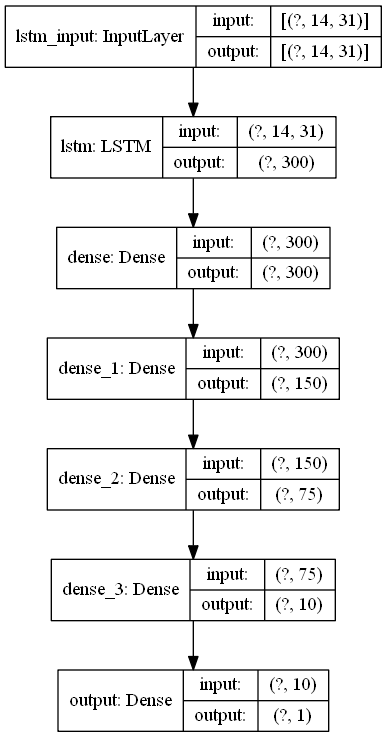

In [47]:
model = create_model()
model.summary()
keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [48]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=10000,
                    epochs=30,
                    shuffle=True,
                    validation_data=valid)

Train on 348 samples, validate on 14 samples
Epoch 1/30
348/348 [==============================] - 2s 7ms/sample - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/30
348/348 [==============================] - 0s 47us/sample - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/30
348/348 [==============================] - 0s 48us/sample - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/30
348/348 [==============================] - 0s 48us/sample - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/30
348/348 [==============================] - 0s 46us/sample - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 6/30
348/348 [==============================] - 0s 47us/sample - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_me

Есть [блокнот](https://www.kaggle.com/bountyhunters/baseline-lstm-with-keras-0-7) с реализованной RNN (LSTM), но без предварительной подготовки данных.